In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error



def manual_openfe_features(df_raw):
    df = df_raw.copy()

    freq_shell = df["Shell weight"].value_counts(normalize=True)
    freq_whole = df["Whole weight"].value_counts(normalize=True)

    freq_feature_shell = df["Shell weight"].map(freq_shell)
    freq_feature_whole = df["Whole weight"].map(freq_whole)
    
    df_manual = pd.DataFrame({
        "f01_Length_div_ShellWeight": df["Length"] / (df["Shell weight"]),
        "f02_Whole1_div_ShellWeight": df["Whole weight.1"] / (df["Shell weight"]),
        "f03_Diameter_div_ShellWeight": df["Diameter"] / (df["Shell weight"]),
        "f05_Length_minus_Shell": df["Length"] - df["Shell weight"],
        "f07_freq_ShellWeight": freq_feature_shell,
        "f08_Max_Whole2_Shell": df[["Whole weight.2", "Shell weight"]].max(axis=1),
        "f09_log_Whole_weight": np.log(df["Whole weight"]),
        "f10_freq_WholeWeight": freq_feature_whole,
        "f11_Shell_plus_Height": df["Shell weight"] + df["Height"],
    })
    
    return df_manual


df = pd.read_csv("train_cleaned_sex_binary.csv")  
y = df["Rings"]
X_raw = df.drop(columns=["Rings", "id"], errors='ignore') 

X_manual = manual_openfe_features(X_raw)
X_final = pd.concat([X_raw.reset_index(drop=True), X_manual], axis=1)
X_final = X_final.drop(columns=["Length", "Whole weight"], errors="ignore")

X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)


def rf_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 4, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': 42,
        'n_jobs': -1
    }

    model = RandomForestRegressor(**params)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    return np.mean(scores)



study = optuna.create_study(direction='maximize')
study.optimize(rf_objective, n_trials=100)


best_params = study.best_trial.params
print("Best Parameters:", best_params)
print("Best CV MSE:", -study.best_value)


best_model = RandomForestRegressor(**best_params)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
final_mse = mean_squared_error(y_test, y_pred)
print("Final Test MSE:", final_mse)


[I 2025-05-26 17:04:44,103] A new study created in memory with name: no-name-6fe99ea2-83d0-4dd5-bfd8-5b9f088776af
[I 2025-05-26 17:04:51,605] Trial 0 finished with value: -3.598844954926927 and parameters: {'n_estimators': 399, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 0 with value: -3.598844954926927.
[I 2025-05-26 17:05:03,613] Trial 1 finished with value: -3.5483678291396465 and parameters: {'n_estimators': 115, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 1 with value: -3.5483678291396465.
[I 2025-05-26 17:06:10,696] Trial 2 finished with value: -3.3182957435342635 and parameters: {'n_estimators': 271, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 2 with value: -3.3182957435342635.
[I 2025-05-26 17:06:56,272] Trial 3 finished with value: -3.3707705416155056 and parameters: {'n_estimators': 118, 'max_depth': 28, 'mi

Best Parameters: {'n_estimators': 390, 'max_depth': 19, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt'}
Best CV MSE: 3.3016372960307443
Final Test MSE: 3.33826123809018


[10/390] trees trained (2.6%)
[20/390] trees trained (5.1%)
[30/390] trees trained (7.7%)
[40/390] trees trained (10.3%)
[50/390] trees trained (12.8%)
[60/390] trees trained (15.4%)
[70/390] trees trained (17.9%)
[80/390] trees trained (20.5%)
[90/390] trees trained (23.1%)
[100/390] trees trained (25.6%)
[110/390] trees trained (28.2%)
[120/390] trees trained (30.8%)
[130/390] trees trained (33.3%)
[140/390] trees trained (35.9%)
[150/390] trees trained (38.5%)
[160/390] trees trained (41.0%)
[170/390] trees trained (43.6%)
[180/390] trees trained (46.2%)
[190/390] trees trained (48.7%)
[200/390] trees trained (51.3%)
[210/390] trees trained (53.8%)
[220/390] trees trained (56.4%)
[230/390] trees trained (59.0%)
[240/390] trees trained (61.5%)
[250/390] trees trained (64.1%)
[260/390] trees trained (66.7%)
[270/390] trees trained (69.2%)
[280/390] trees trained (71.8%)
[290/390] trees trained (74.4%)
[300/390] trees trained (76.9%)
[310/390] trees trained (79.5%)
[320/390] trees trai

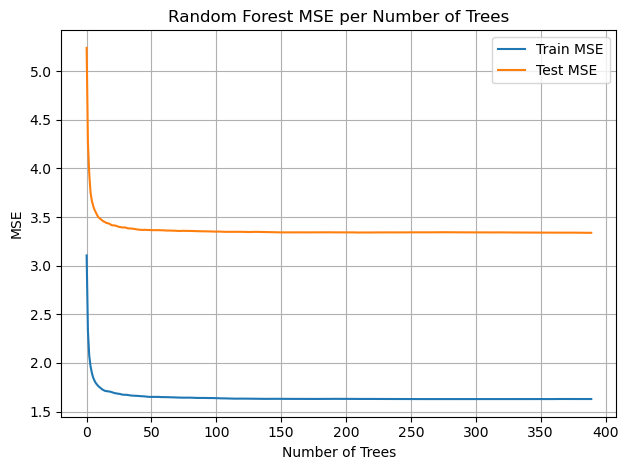

In [11]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
from math import sqrt
import matplotlib.pyplot as plt


df = pd.read_csv("train_cleaned_sex_binary.csv")  
y = df["Rings"]
X_raw = df.drop(columns=["Rings", "id"], errors='ignore') 

# 构造特征
def manual_openfe_features(df_raw):
    df = df_raw.copy()
    freq_shell = df["Shell weight"].value_counts(normalize=True)
    freq_whole = df["Whole weight"].value_counts(normalize=True)
    freq_feature_shell = df["Shell weight"].map(freq_shell)
    freq_feature_whole = df["Whole weight"].map(freq_whole)
    df_manual = pd.DataFrame({
        "f01_Length_div_ShellWeight": df["Length"] / (df["Shell weight"]),
        "f02_Whole1_div_ShellWeight": df["Whole weight.1"] / (df["Shell weight"]),
        "f03_Diameter_div_ShellWeight": df["Diameter"] / (df["Shell weight"]),
        "f05_Length_minus_Shell": df["Length"] - df["Shell weight"],
        "f07_freq_ShellWeight": freq_feature_shell,
        "f08_Max_Whole2_Shell": df[["Whole weight.2", "Shell weight"]].max(axis=1),
        "f09_log_Whole_weight": np.log(df["Whole weight"]),
        "f10_freq_WholeWeight": freq_feature_whole,
        "f11_Shell_plus_Height": df["Shell weight"] + df["Height"],
    })
    return df_manual

X_manual = manual_openfe_features(X_raw)
X_final = pd.concat([X_raw.reset_index(drop=True), X_manual], axis=1)
X_final = X_final.drop(columns=["Length", "Whole weight"], errors="ignore")
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)


best_params = {
    'n_estimators': 390,
    'max_depth': 19,
    'min_samples_split': 9,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'random_state': 42,
    'n_jobs': -1
}


train_mse_per_round = []
test_mse_per_round = []

for n in range(1, best_params['n_estimators'] + 1):
    model = RandomForestRegressor(**{**best_params, 'n_estimators': n})
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    train_mse = mean_squared_error(y_train, train_pred)
    test_mse = mean_squared_error(y_test, test_pred)
    train_mse_per_round.append(train_mse)
    test_mse_per_round.append(test_mse)

    if n % 10 == 0 or n == best_params['n_estimators']:
        percent = n / best_params['n_estimators'] * 100
        print(f"[{n}/{best_params['n_estimators']}] trees trained ({percent:.1f}%)")


final_model = RandomForestRegressor(**best_params)
final_model.fit(X_train, y_train)
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmsle = sqrt(mean_squared_log_error(y_train, np.maximum(0, y_train_pred)))
test_rmsle = sqrt(mean_squared_log_error(y_test, np.maximum(0, y_test_pred)))

print(f"Train R²: {train_r2:.4f}, RMSLE: {train_rmsle:.4f}")
print(f"Test R²:  {test_r2:.4f}, RMSLE: {test_rmsle:.4f}")

plt.plot(train_mse_per_round, label='Train MSE')
plt.plot(test_mse_per_round, label='Test MSE')
plt.xlabel("Number of Trees")
plt.ylabel("MSE")
plt.title("Random Forest MSE per Number of Trees")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("random_forest_mse_plot.png", dpi=300)
plt.show()